# Calculating a cost function

Now we look at the method for comparing real patient data with the forward model using the Brain class and other functions we have developed so far. The cost function calculations will form the heart of the MCMC.

Import some necessary modules.

In [37]:
import sys, os
sys.path.append("..")

#SCFC modules
from forward import network_transfer as nt
from utils import path as pth
from utils import functions
from brain import Brain

#generic modules
import matplotlib.pyplot as mpl
import numpy as np
import time
%matplotlib inline
from scipy.signal import decimate

## Importing filtered data

First, let's import some patient data for a single patient. It has been transformed to filtered spectral data as discussed in the notebook 'ChangMEG-data-preprocessing'.

In [15]:
MEG_path = '/Users/Megan/RajLab/MEG-chang' #insert appropriate path here.
directories = pth.walk_tree(MEG_path)
data = 'DK_timecourse_20_filtered.h5'
freqs = 'DK_timecourse_20_filterfreqs.h5'

In [16]:
dir = directories[0]
abspath = os.path.join(MEG_path,dir)
data_path = os.path.join(abspath, data)
FMEGdata = pth.read_hdf5(data_path)
freq_path = os.path.join(abspath, freqs)
f = pth.read_hdf5(freq_path)

Text(0,0.5,'Magnitude (dB)')

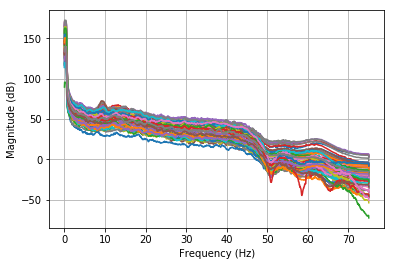

In [21]:
fig = mpl.figure(num=5, figsize = (6,4))
for key in FMEGdata.keys():
    mpl.plot(f,functions.mag2db(FMEGdata[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

In [104]:
FMEGdata.keys()

dict_keys(['LHbankssts', 'LHcaudalanteriorcingulate', 'LHcaudalmiddlefrontal', 'LHcuneus', 'LHentorhinal', 'LHfrontalpole', 'LHfusiform', 'LHinferiorparietal', 'LHinferiortemporal', 'LHinsula', 'LHisthmuscingulate', 'LHlateraloccipital', 'LHlateralorbitofrontal', 'LHlingual', 'LHmedialorbitofrontal', 'LHmiddletemporal', 'LHparacentral', 'LHparahippocampal', 'LHparsopercularis', 'LHparsorbitalis', 'LHparstriangularis', 'LHpericalcarine', 'LHpostcentral', 'LHposteriorcingulate', 'LHprecentral', 'LHprecuneus', 'LHrostralanteriorcingulate', 'LHrostralmiddlefrontal', 'LHsuperiorfrontal', 'LHsuperiorparietal', 'LHsuperiortemporal', 'LHsupramarginal', 'LHtemporalpole', 'LHtransversetemporal', 'RHbankssts', 'RHcaudalanteriorcingulate', 'RHcaudalmiddlefrontal', 'RHcuneus', 'RHentorhinal', 'RHfrontalpole', 'RHfusiform', 'RHinferiorparietal', 'RHinferiortemporal', 'RHinsula', 'RHisthmuscingulate', 'RHlateraloccipital', 'RHlateralorbitofrontal', 'RHlingual', 'RHmedialorbitofrontal', 'RHmiddletempo

## Downsampling

We need to downsample the data to have fewer frequency points. Currently, there are 4488. It would be better to have something close to 150. We can first find the step between adjacent frequencies to figure out roughly how often we should be selecting samples.

### Downsampling using 'decimate'

In [25]:
deltaf = (f[1]-f[0])
print(deltaf)

0.016714954312458213


In [34]:
desired_delta = f[4487]/150
step = desired_delta/deltaf
print(step)

29.913333333333334


This suggests that the best thing to do here is to take every 30 points from the data. In fact, let's try to use the scipy decimate function instead of writing a resampler from scratch. We will also first cut off the very low freqeuncy data to try to mitigate some of the edge effects.

In [66]:
2/deltaf

119.65333333333334

In [76]:
reducef = f[120:]
reducedata = {}
for key in FMEGdata.keys():
    reducedata[key] = FMEGdata[key][120:]

In [77]:
downsampled = decimate(functions.mag2db(reducedata['LHinsula']), 3)
downsampled2 = decimate(downsampled, 10) #suggested you apply it twice in documentation.

/Users/Megan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


In [80]:
downf = decimate(reducef, 30)

/Users/Megan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


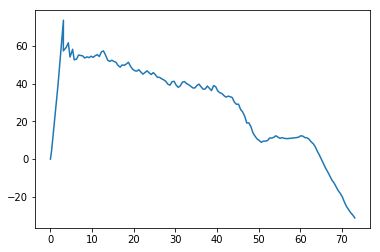

In [81]:
mpl.plot(downf,downsampled2)

(0, 45)

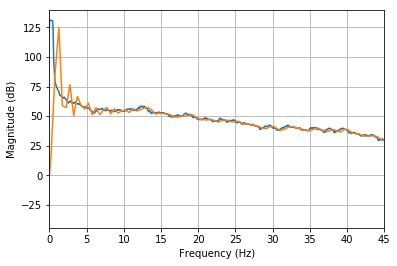

In [64]:
fig2 = mpl.figure(num=5, figsize = (6,4))

mpl.plot(f,functions.mag2db(FMEGdata['LHinsula']))
mpl.plot(downf, downsampled2)

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
mpl.xlim(0,45)

In summary, this doesn't work very well. Although it seems like the 'dumb and simple' thing to do, for now I am going to stick with just choosing a limited number of the data points. 

### Downsampling the 'KISS (Keep It Simple Stupid)' way

For now, I am going to take every thirty of the data points, and the frequency axis. Define a function to do this, where 'n' is the number of points desired.

In [99]:
import math
def down_sample(dataarray, n):

    step = math.floor(len(dataarray)/n)

    output = np.empty(n)
    i = 0
    while i < n:
        j = i*step
        output[i] = dataarray[j]
        i += 1
    return output

In [100]:
newf = down_sample(f, 150)
len(newf)

150

Text(0,0.5,'Magnitude (dB)')

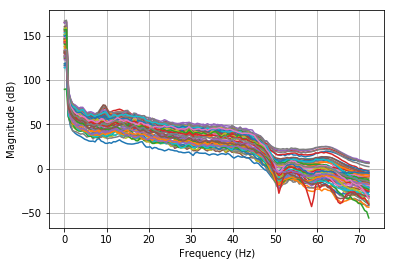

In [101]:
fig3 = mpl.figure(num=5, figsize = (6,4))
downsample = {}
for key in FMEGdata.keys():
    downsample[key] = down_sample(FMEGdata[key], 150)
    mpl.plot(newf,functions.mag2db(downsample[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

Compare the unsampled to the raw data.

Text(0,0.5,'Magnitude (dB)')

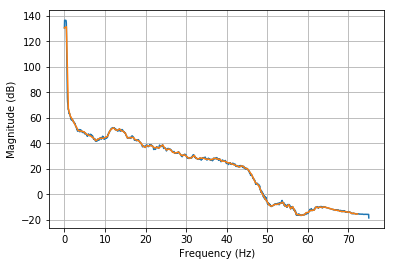

In [105]:
fig4 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(f,functions.mag2db(FMEGdata['LHbankssts']))
mpl.plot(newf,functions.mag2db(downsample['LHbankssts']))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

We only want to work with 2-45Hz data, so we can trim the data before we downsample it (and hopefully improve the capturing of details).

In [106]:
45/deltaf

2692.2

In [108]:
fnew = f[120:2692]
newdata = {}
for key in FMEGdata.keys():
    newdata[key] = FMEGdata[key][120:2692]

Text(0,0.5,'Magnitude (dB)')

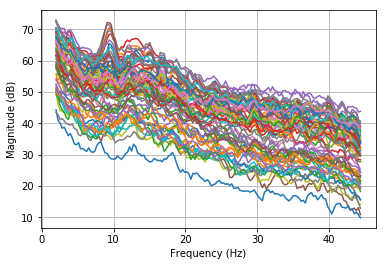

In [109]:
fig5 = mpl.figure(num=5, figsize = (6,4))
downsample = {}
newf = down_sample(fnew, 150)
for key in FMEGdata.keys():
    downsample[key] = down_sample(newdata[key], 150)
    mpl.plot(newf,functions.mag2db(downsample[key]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

Again, let's compare a region to the undownsampled form.

Text(0,0.5,'Magnitude (dB)')

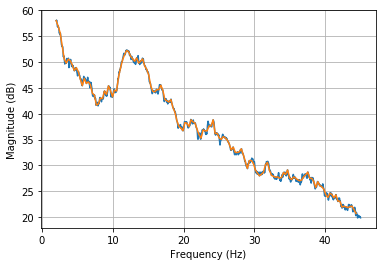

In [110]:
fig6 = mpl.figure(num=5, figsize = (6,4))
mpl.plot(fnew,functions.mag2db(newdata['LHbankssts']))
mpl.plot(newf,functions.mag2db(downsample['LHbankssts']))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

In [111]:
len(downsample['LHbankssts'])

150

In [112]:
len(newdata['LHbankssts'])

2572

This seems to be a reasonable reduction in the number of points in the data.

### Detrending?

Let's try the scipy detrend function and see whether that can assist with our experimental background trend that is not a feature we wish to reproduce with the model.

In [113]:
from scipy.signal import detrend

## Setting up brain class instance

Now that we've got that, let's set up a brain class instance to contain the connectivity and distance matrices, corrected as required by the model.

## Example of forward model calculation

Now, we can do an example of the forward model calculation for the range of frequencies that we found from the filtered data (after they had been downsampled).

## Calculating cost using Pearson correlation

## Alternative cost function calculations

We have the option of different cost functions. This is an example of that -- using the KS () statistic.